# Exploring Regression Models With Statcast

Using Statcast Expected models as a predictive metric has become somewhat of a baseball discourse fallacy that I wanted to explore. Here I wanted to test using three data points: wOBA, xwOBA, and xwOBACON to create a Predicted wOBA using a simple regression analysis (using past performance to explain future outcomes). 

There are other methods I want to explore this topic with but I think the overall conclusion is that while our model did pretty good created a predicted wOBA, I think that is more a reflection of what goes into xwOBA than xwOBA itself, mainly launch speed, and launch angle. 

It gives us opportunities to explore, both in methodology (specifically a more Bayesian approach of probabilities vs. point estimates to building our model), and in the parts that go into it (spray angle, contact quality, etc).

Either way, for its flaws, this model is still interesting to play with in Python!

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('chained_assignment', None)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style('whitegrid');
import scipy.stats as stats
import numpy as np

In [3]:
batter_df = pd.read_csv(r'../data/statcastbatter.csv')
batter_df_2021 = pd.read_csv(r'../data/statcastbatter2021.csv')
batter_df['player_name'] = [" ".join(n.split(", ")[::-1]) for n in batter_df['player_name']]
batter_df_2021['player_name'] = [" ".join(n.split(", ")[::-1]) for n in batter_df_2021['player_name']]

Here I upload the CSV of Statcast data from 2015 through 2020, and a separate one for 2021. The model will be built using data from 2015-2020, and tested against the outcome of 2021. Added to this is xwOBACON (Expected wOBA on Contact).

<Figure size 1008x576 with 0 Axes>

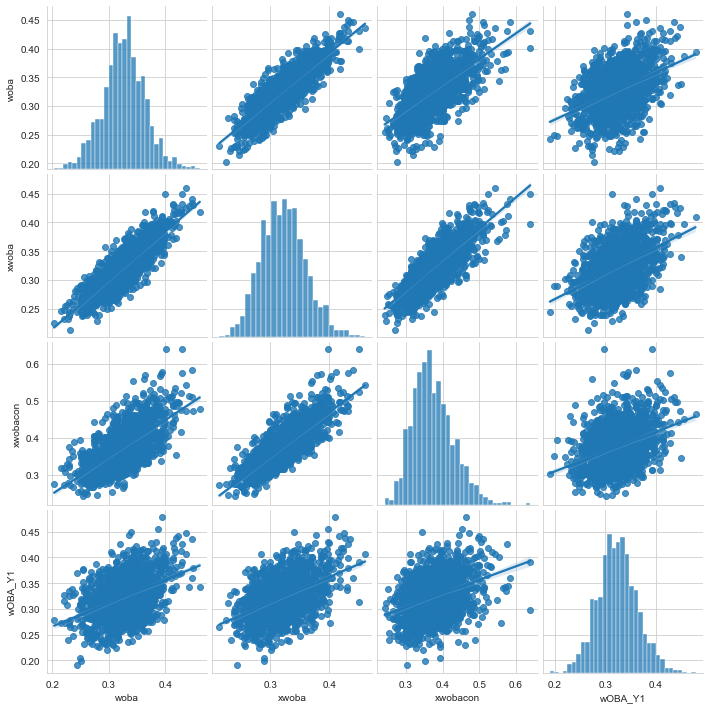

In [4]:
# Creating next year wOBA as wOBA_Y1 with a copy of the dataframe.
batter_df_copy = batter_df.copy()
batter_df_copy['wOBA_Y1'] = batter_df_copy.sort_values(['player_name', 'season'], ascending=False).groupby('player_name')['woba'].shift()
batter_df_copy = batter_df_copy.loc[batter_df_copy['wOBA_Y1'].notnull()]
batter_df_copy.loc[batter_df_copy['player_name'] == "Travis d'Arnaud", ['player_name', 'season', 'woba', 'xwoba', 'wOBA_Y1']].sort_values(by='season').head(3)

# Pearson correlation
batter_df_copy.corr()[['wOBA_Y1']].sort_values(by='wOBA_Y1', ascending=False)

# Pairplot to visually see correlation
plt.figure(figsize=(14, 8))
sns.pairplot(batter_df_copy[['woba', 'xwoba', 'xwobacon', 'wOBA_Y1']], kind="reg")

Here we can see our Pearson correlations of next season wOBA across the three components we're going to use to build our model, specifically actual wOBA, xwOBA, and xwOBACON.

In [5]:
# Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = batter_df_copy[['woba', 'xwoba', 'xwobacon']].values
y = batter_df_copy[['wOBA_Y1']].values

# Split data into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

Using sklearn we build our model. You can check the [documentation here](https://scikit-learn.org/stable/). X will be our training data, y will be our test data. If you want to check the mean absolute error of the training and test data you can run the code below.

In [6]:
# Mean absolute error of training data
print('Mean wOBA:', X_train[:,0].mean())
print('Mean absolute error:', mean_absolute_error(y_pred, y_train))

# Mean absolute error of test data
y_pred = lr.predict(X_test)
print('Mean wOBA:', X_test[:,0].mean())
print('Mean absolute error:', mean_absolute_error(y_pred, y_test))

Mean wOBA: 0.3266621160409556
Mean absolute error: 0.02746135631002911
Mean wOBA: 0.3277440273037543
Mean absolute error: 0.028648367343451143


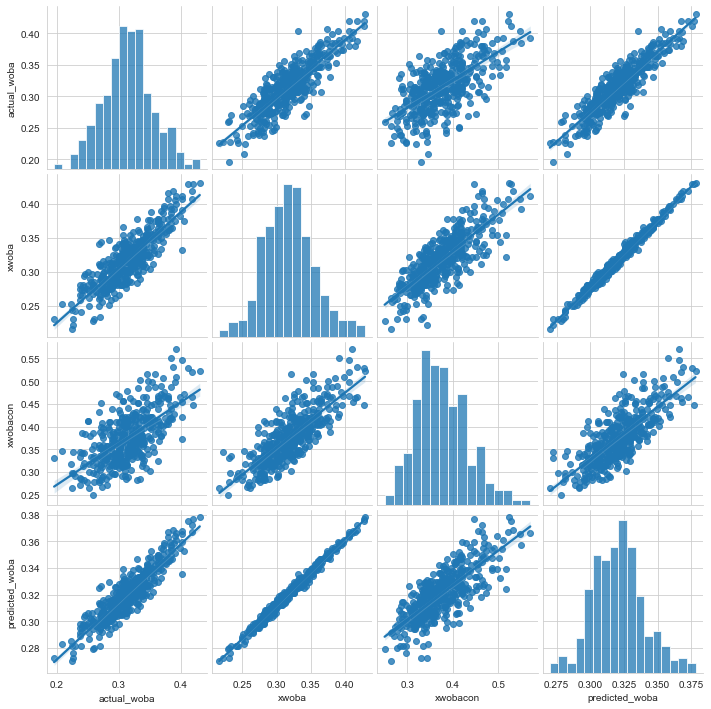

In [9]:
# Here we test our model to 2021 stats, cleaning 2021 data with another copy.

batter_2021_copy = batter_df_2021.copy()

X = batter_2021_copy[['woba', 'xwoba', 'xwobacon']].values
y = batter_2021_copy[['woba']].values

y_pred = lr.predict(X)

batter_2021_copy['predicted_woba'] = y_pred
batter_2021_copy['Season'] = 2021
batter_2021_copy = batter_2021_copy.rename(columns={'woba':'actual_woba'})
batter_2021_copy.loc[: ,['season', 'player_name', 'actual_woba', 'predicted_woba']].head(15)

batter_2021_copy['pred_act'] = batter_2021_copy['predicted_woba'] - batter_2021_copy['actual_woba']
batter_2021_copy.corr()[['predicted_woba']].sort_values(by='predicted_woba', ascending=False)
sns.pairplot(batter_2021_copy[['actual_woba', 'xwoba', 'xwobacon', 'predicted_woba']], kind="reg")

Pairplot now to include our Predicted wOBA, as well as a line you can run to see the correlation.

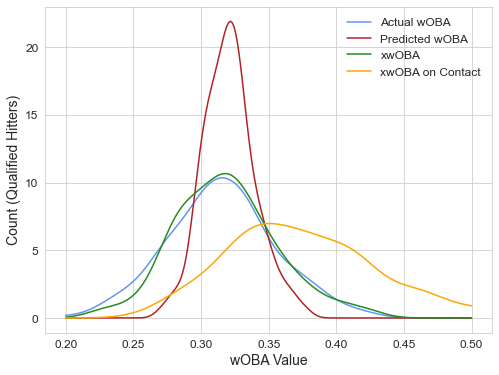

In [10]:
kde_woba = stats.gaussian_kde(batter_2021_copy['actual_woba'])
kde_model = stats.gaussian_kde(batter_2021_copy['predicted_woba'])
kde_xwoba = stats.gaussian_kde(batter_2021_copy['xwoba'])
kde_xwobacon = stats.gaussian_kde(batter_2021_copy['xwobacon'])
x = np.linspace(0.20,0.50,1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, kde_woba(x), color="cornflowerblue", label='Actual wOBA')
ax.plot(x, kde_model(x), color="firebrick", label='Predicted wOBA')
ax.plot(x, kde_xwoba(x), color="forestgreen", label='xwOBA')
ax.plot(x, kde_xwobacon(x), color="orange", label='xwOBA on Contact')
plt.xlabel("wOBA Value",fontsize=14)
plt.ylabel("Count (Qualified Hitters)", fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(frameon=False, fontsize=12)
plt.show()

This Gaussian Kernel Density Estimation shows how wonky our model is though, and you can check the data frame yourself. The correlation is strong but it's not to scale to league average, causing our model wOBA to be concentrated around the league average. To fix this we need to scale our model using the following code.

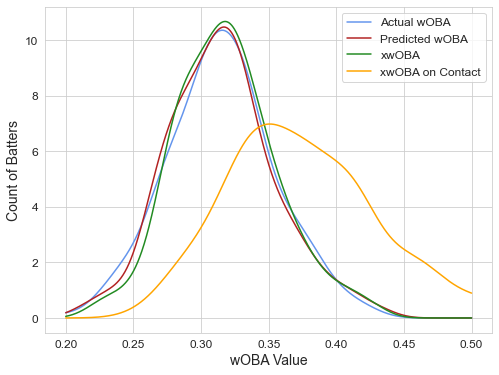

In [11]:
league_woba_mean = batter_2021_copy['actual_woba'].mean()
league_woba_std = batter_2021_copy['actual_woba'].std()
batter_2021_copy['scaled_model'] = league_woba_mean + (batter_2021_copy['predicted_woba'] - batter_2021_copy['predicted_woba'].mean()) * (league_woba_std/batter_2021_copy['predicted_woba'].std())

kde_woba = stats.gaussian_kde(batter_2021_copy['actual_woba'])
kde_model = stats.gaussian_kde(batter_2021_copy['scaled_model'])
kde_xwoba = stats.gaussian_kde(batter_2021_copy['xwoba'])
kde_xwobacon = stats.gaussian_kde(batter_2021_copy['xwobacon'])
x = np.linspace(0.20,0.50,1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, kde_woba(x), color="cornflowerblue", label='Actual wOBA')
ax.plot(x, kde_model(x), color="firebrick", label='Predicted wOBA')
ax.plot(x, kde_xwoba(x), color="forestgreen", label='xwOBA')
ax.plot(x, kde_xwobacon(x), color="orange", label='xwOBA on Contact')
plt.xlabel("wOBA Value",fontsize=14)
plt.ylabel("Count of Batters", fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(frameon=True, fontsize=12)
plt.show()

* Top 10 wOBA Leaderboard

In [12]:
batter_2021_copy['pred_act'] = batter_2021_copy['scaled_model'] - batter_2021_copy['actual_woba']
batter_2021_copy.loc[: ,['season', 'player_name', 'actual_woba', 'xwoba', 'scaled_model', 'pred_act']].sort_values('actual_woba', ascending=False).head(10)

,season,player_name,actual_woba,xwoba,scaled_model,pred_act
0,2021,"Harper, Bryce",0.431,0.430,0.434975,0.003975
2,2021,"Soto, Juan",0.420,0.429,0.432619,0.012619
10,2021,"Buxton, Byron",0.419,0.407,0.412573,-0.006427
4,2021,"Guerrero Jr., Vladimir",0.419,0.418,0.422730,0.003730
1,2021,"Acuña Jr., Ronald",0.412,0.429,0.429872,0.017872
33,2021,"Belt, Brandon",0.406,0.374,0.381921,-0.024079
139,2021,"Schwindel, Frank",0.403,0.332,0.346338,-0.056662
18,2021,"Winker, Jesse",0.403,0.390,0.395658,-0.007342
9,2021,"Tatis Jr., Fernando",0.403,0.407,0.408735,0.005735
6,2021,"Grandal, Yasmani",0.402,0.412,0.413937,0.011937
